In [1]:
%matplotlib inline

A few basic libraries that we'll need for the initial exercises:

In [2]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

'''
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
'''

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [3]:
import utils; reload(utils)
from utils import plots
import os, sys

current_dir = os.getcwd()

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [4]:
#Create references to important directories we will use over and over
PROJ_HOME_DIR = current_dir + '/data/statefarm/'
DATA_HOME_DIR = PROJ_HOME_DIR + 'sample/'

results_path = DATA_HOME_DIR + 'results/'
test_path = DATA_HOME_DIR + 'test/'
valid_path = DATA_HOME_DIR + 'valid/'
train_path = DATA_HOME_DIR + 'train/'

Set up kaggle config for this competition (after agreeing to rules).

In [5]:
#kg config -g -u `username` -p `password` 
#dogs-vs-cats-redux-kernels-edition
#state-farm-distracted-driver-detection
#
#!kg config -c 'state-farm-distracted-driver-detection'
#!kg download
#!unzip -q sample_submission.csv.zip
#!unzip -q imgs.zip
#!unzip -q driver_imgs_list.csv.zip

### Data set-up

In [6]:
## Create directories
#%mkdir valid
#%mkdir results
#%mkdir -p sample/train
#%mkdir -p sample/test
#%mkdir -p sample/valid
#%mkdir -p sample/results
#%mkdir -p test/unknown

Split training and validation set such that a percentage of drivers in the validation set are not in the training set.


In [7]:
## Read names of training images from .csv file
#%cd $DATA_HOME_DIR/

#driver_imgs_data=pd.read_csv('driver_imgs_list.csv')
##train_imgs = driver_imgs_data['img'].tolist()

#by_drivers = driver_imgs_data.groupby('subject')
#unique_drivers = np.random.permutation(by_drivers.groups.keys())
## Set validation set percentage with regards to training set
#val_pct = 0.2

##random.shuffle(unique_drivers)

## These are the drivers we will be entirely moving to the validation set
#val_drivers = unique_drivers[:int(len(unique_drivers) * val_pct)]

#val_data = driver_imgs_data.loc[driver_imgs_data['subject'].isin(val_drivers)]

In [8]:
## Create sub-directories in valid/
#for index, row in val_data.iterrows():
#    directory = DATA_HOME_DIR+'valid/'+row['classname']
#    if not os.path.exists(directory):
#        os.mkdir(directory)
        
## Move validation data from training data
#for index, row in val_data.iterrows():
#    os.rename(DATA_HOME_DIR+'train/'+row['classname']+'/'+row['img'],\
#              DATA_HOME_DIR+'valid/'+row['classname']+'/'+row['img'])

In [9]:
#from shutil import copyfile

#%cd $DATA_HOME_DIR/train
#%mkdir ../sample
#%mkdir ../sample/train
#%mkdir ../sample/valid
#for d in glob('c?'):
#    os.mkdir('../sample/train/'+d)
#    os.mkdir('../sample/valid/'+d)
#g = glob('c?/*.jpg')
#shuf = np.random.permutation(g)
#for i in range(1500): copyfile(shuf[i], '../sample/train/' + shuf[i])

#%cd ../valid
#g = glob('c?/*.jpg')
#shuf = np.random.permutation(g)
#for i in range(1000): copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [10]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [11]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [12]:
vgg = Vgg16()

#vgg.model.load_weights(results_path+'mod_wts.h5')

### Create batches

In [13]:
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
#(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
#    test_filename) = vgg.get_classes(PROJ_HOME_DIR)

# Adapt model to our data
vgg.finetune(batches)

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


### Train

In [19]:
vgg.model.optimizer.lr = 1e-5
vgg.fit(batches, val_batches, nb_epoch=2)
vgg.model.optimizer.lr = 1e-3
vgg.fit(batches, val_batches, nb_epoch=4)
vgg.model.save_weights(results_path+'mod_wts.h5')

Epoch 1/2
1500/1500 [==============================] - 63s - loss: 1.0150 - acc: 0.6600 - val_loss: 1.4511 - val_acc: 0.5160
Epoch 2/2
1500/1500 [==============================] - 62s - loss: 0.9597 - acc: 0.6980 - val_loss: 1.4982 - val_acc: 0.4880
Epoch 1/4
1500/1500 [==============================] - 63s - loss: 0.9322 - acc: 0.6967 - val_loss: 1.5244 - val_acc: 0.5230
Epoch 2/4
1500/1500 [==============================] - 63s - loss: 0.8592 - acc: 0.7093 - val_loss: 1.5353 - val_acc: 0.5010
Epoch 3/4
1500/1500 [==============================] - 63s - loss: 0.8520 - acc: 0.7160 - val_loss: 1.6072 - val_acc: 0.4640
Epoch 4/4
1500/1500 [==============================] - 63s - loss: 0.8679 - acc: 0.7080 - val_loss: 1.6114 - val_acc: 0.5010


<CudaNdarrayType(float32, scalar)>


In [17]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Test

In [ ]:
batches, preds = vgg.test(test_path, batch_size = batch_size)
#batches, preds = vgg.test(test_path, batch_size = batch_size*2)
filenames = batches.filenames

#Save our test results arrays so we can use them again later
utils.save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [ ]:
print(preds[:5])

print(filenames[:5])

#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + 'unknown/'+ filenames[2])

In [13]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

Found 2000 images belonging to 2 classes.


[[981  19]
 [ 23 977]]


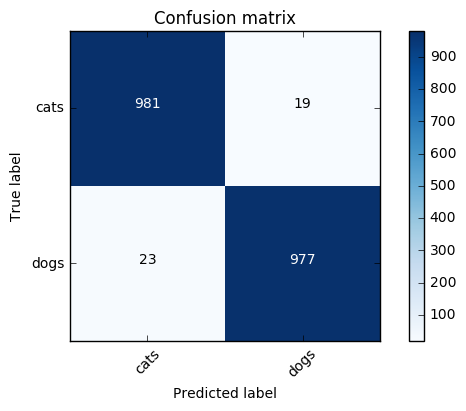

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
utils.plot_confusion_matrix(cm, val_batches.class_indices)


### Create .csv file for submission to Kaggle
For each image in the test set, you should predict a probability that the image is a dog (1.0 = dog, 0.0 = cat).

e.g. [['id', 'label'],[1,0.5],[2,0.5],[3,0.5],...]

In [24]:
input_ids = [int(x[len('unknown/'):-len('.jpg')]) for x in batches.filenames]
    
list_out = sorted(zip(input_ids,np.clip(preds[:,1],0.05,0.95)))

list_out = [('id','label')]+list_out # add column labels

print(list_out[:15])

[('id', 'label'), (1, 0.94999999), (2, 0.94999999), (3, 0.94999999), (4, 0.94999999), (5, 0.050000001), (6, 0.050000001), (7, 0.050000001), (8, 0.050000001), (9, 0.050000001), (10, 0.050000001), (11, 0.050000001), (12, 0.94999999), (13, 0.050000001), (14, 0.050000001)]


In [25]:
import csv

with open("data/dogscats/kaggle/dogscats_predictions4.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(list_out)

In [26]:
! kg submit data/dogscats/kaggle/dogscats_predictions4.csv

Starting new HTTPS connection (1): www.kaggle.com



### Create linear model

In [ ]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax', W_regularizer=l2(0.01))
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)